# Text Processing 
## Little Wizard Stories of Oz by Frank Baum

In [1]:
import operator
from collections import Counter
import spacy
from spacy.en import English
import textacy  # Higher level package built on spacy -- provides easier tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nlp = spacy.load('en')
%matplotlib inline

In [2]:
# Read document
with open('../data/pg25519.txt', 'r') as f:
    read_file = f.read()

## Project Gutenberg Remove Header and Footer
Text files from Project Gutenberg have a specific start and end of file notation. I modified mine to start slightly further in the file where you could visably see a block of new line characters where a segmentation would be more logical for the content of the file. 

In [3]:
# After the start text there is a block of new line characters we can split by.
file_start = read_file.split('\n\n\n\n\n\n\n\n')[-1]  
# The end is notated similar to the start.
file_full = file_start.split('***END OF THE PROJECT GUTENBERG EBOOK LITTLE WIZARD STORIES OF OZ***')[0]
file_full = file_full.replace('[Illustration]', '').replace('\n', ' ') # Replace unnecessary words or chars

## Parse Stories 
Using the provided table of contents we can see the headers where to split the text from. Also load into spaCy. 

In [4]:
the_cowardly_lion_and_the_hungry_tiger = file_full.split('THE COWARDLY LION AND THE HUNGRY TIGER')[1]\
.split('LITTLE DOROTHY AND TOTO')[0]

little_dorothy_and_toto = file_full.split('LITTLE DOROTHY AND TOTO')[1]\
.split('TIKTOK AND THE NOME KING')[0]

ticktok_and_the_nome_king = file_full.split('TIKTOK AND THE NOME KING')[1]\
.split('OZMA AND THE LITTLE WIZARD')[0]

ozma_and_the_little_wizard = file_full.split('OZMA AND THE LITTLE WIZARD')[1]\
.split('JACK PUMPKINHEAD AND THE SAWHORSE')[0]

jack_pumpkinhead_and_the_sawhorse = file_full.split('JACK PUMPKINHEAD AND THE SAWHORSE')[1]\
.split('THE SCARECROW AND THE TIN WOODMAN')[0]

the_scarecrow_and_the_tin_woodman = file_full.split('THE SCARECROW AND THE TIN WOODMAN')[1]\
.split('But the Tin Woodmanwas very careful not to stand up in the boat again.')[0] + \
                                        ' But the Tin Woodman was very careful not to stand up in the boat again.'
    
# Create list of documents for corpus 
documents = [the_cowardly_lion_and_the_hungry_tiger, little_dorothy_and_toto, ticktok_and_the_nome_king,\
            ozma_and_the_little_wizard, jack_pumpkinhead_and_the_sawhorse, the_scarecrow_and_the_tin_woodman]
document_names = ['the_cowardly_lion_and_the_hungry_tiger', 'little_dorothy_and_toto', 'ticktok_and_the_nome_king',\
            'ozma_and_the_little_wizard', 'jack_pumpkinhead_and_the_sawhorse', 'the_scarecrow_and_the_tin_woodman']

## Pre-processing
lower case, remove punctuation, stop words, stemming/lemmatization, etc.

In [5]:
def cleaning_and_preprocessing(doc):
    """ Function to clean and run the text pre-processing steps.
    1. Lowercase
    2. Punctuation
    3. Stopwords
    4. Stemming
    :param doc: string
    :returns: spacy doc object
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    
    # Stemming/lemmatization
    doc = [w.lemma_ for w in nlp(doc)]
    
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc if not w in spacy.en.STOP_WORDS]
    
    # Custom stopwords to remove
    rm = ['-PRON-', ' ', '      ', '   ', '   ', '   ']
    doc = [w for w in doc if not w in rm]
    
    # Additional normalization using textacy
    doc = [textacy.preprocess_text(w) for w in doc]
    
    return doc

In [6]:
# Creating a textacy corpus of the document with metadata as the name
corpus = textacy.Corpus('en', metadatas=None)
for idx, i in enumerate(documents):
    meta = {'name': document_names[idx]}
    text = cleaning_and_preprocessing(i)
    doc = textacy.Doc(' '.join(text), lang='en', metadata=meta)
    corpus.add_doc(doc, metadata=meta)

## Term Document Frequency 
Identify the frequency of terms that are found within the full document n times. 

In [7]:
# At least 50x 
doc = cleaning_and_preprocessing(file_full)
ds = pd.Series(doc)  # Pandas series object
fifty = ds.value_counts()
print(fifty[fifty >= 50])  # 50 and above

wizard    51
little    50
dtype: int64


In [8]:
# At least 10x
ten = ds.value_counts()
print(ten[ten >= 10].head(10))  # Printing only the top ten for brevity.

wizard       51
little       50
man          45
head         41
scarecrow    40
king         38
ozma         38
tin          36
jack         33
good         33
dtype: int64


## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

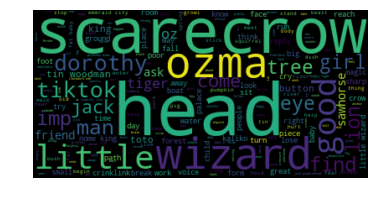

In [9]:
wordcloud = WordCloud().generate(' '.join(doc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

![worcloud](./../img/wordcloud1.png)

## TF-IDF, LSA and Cosine Distance
*TF-IDF* A conventional weighting schema. Each entry in the matrix corresponds to the term weighting in the document. When a term is important it is expected to frequently appear within a document but less within the corpus. 

*Latent Semantic Analysis* provides insight into the relationship between words in the documents.

*Cosine Distance* Measures the angle between vectors. When we have a low cosine (cos0) the documents are similar, when it's high (cos90) the documents do not match. Textacy operates on a interval of 0.0 to 1.0 when the higher values correspond to more similar objects. 

In [10]:
# Vectorized corpus
vectorizer = textacy.Vectorizer(weighting='tfidf', normalize=True, smooth_idf=True, \
                        min_df=1, max_df=0.95, max_n_terms=100000)
# Create a document term matrix 
doc_term_matrix = vectorizer.fit_transform(corpus)
print(doc_term_matrix.shape)

(6, 4574)


In [11]:
# LSA Model - built upon sklearn 
model = textacy.tm.TopicModel('lsa')
model.fit(doc_term_matrix)

# LSA Model interpretation
doc_topic_matrix = model.transform(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=[0,1]):
    print('topic', topic_idx, ':', str(top_terms))

topic 0 : (cat, wish, answer, boat, carry, manage, hesitate, answer, like, lake)
topic 1 : (bed, afterward, tumble, stop, bump, tree, dozen, foot, away, sit)


## Cosine Similarity
Using premade word vectors we can use textacys similarity function to measure semantic similarity from our documents and phrases. The method I used uses the cosine distance between the paramets using word2vec vectors. 

*NOTE* the term "scarecrow" is not included in the available word vector representations and is is not finding a match. To perform this we would need to make custom word vectors.

In [12]:
def find_similar_document_to_term(corpus, term):
    ''' Pass in a list of documents and a term to idenfity the most similar result using cosine similarity
    
    :param corpus: list of documents (strings)
    :param term: string
    :returns: tuple of the (score, document name)
    '''
    term = nlp(term)
    scores = []
    for idx, i in enumerate(corpus):
        processed_doc = nlp(' '.join(cleaning_and_preprocessing(i)))
        #score = processed_doc.similarity(scarecrow)
        score = textacy.similarity.word2vec(processed_doc, term)
        scores.append(score)
    index, value = max(enumerate(scores), key=operator.itemgetter(1))
    return document_names[index], value #score, document

print('Lion \nDocument: ' + find_similar_document_to_term(documents, 'lion')[0] + '\nScore: ' + \
      str(find_similar_document_to_term(documents, 'lion')[1]) + '\n')
print('Wizard \nDocument: ' + find_similar_document_to_term(documents, 'wizard')[0] + '\nScore: ' + \
      str(find_similar_document_to_term(documents, 'wizard')[1]) + '\n')

# Scarecrow - term is not found in vector representations. See following commands.
print('Scarecrow \nDocument: ' + find_similar_document_to_term(documents, 'scarecrow')[0] + '\nScore: ' + \
      str(find_similar_document_to_term(documents, 'scarecrow')[1]) + '\n')
# Lookup vector in spacy vocab
parser = English()
scarecrow = parser.vocab['scarecrow']
print('Can scarecrow be represented as a vector?', scarecrow.has_vector)

Lion 
Document: the_cowardly_lion_and_the_hungry_tiger
Score: 0.551932293052

Wizard 
Document: ozma_and_the_little_wizard
Score: 0.424771118594

Scarecrow 
Document: the_cowardly_lion_and_the_hungry_tiger
Score: 0.0

Can scarecrow be represented as a vector? False


## Zipf Plot

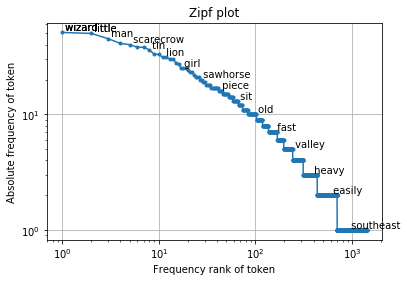

In [13]:
from pylab import *

# Pick a lowercasing function according to Python version
lower = str.lower

# The data: token counts from the Brown corpus
tokens_with_count = Counter(map(lower, cleaning_and_preprocessing(file_full)))
#Dictionary keys in Python 3 aren't indexable, so store the tokens as a list.
#The list is sorted to prevent changes in display text on repeated runs.
tokens = sorted([k for k in tokens_with_count.keys()])
counts = array([tokens_with_count[k] for k in tokens])

# A Zipf plot
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
loglog(ranks, frequencies, marker=".")
title("Zipf plot")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)), 20).astype(int)):
    try:
        dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                     verticalalignment="bottom",
                     horizontalalignment="left")
    except:
        pass
show()

### Resources

* (Zipf Plot - Python 3) https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c

* (Zipf Plot) https://gist.github.com/fnielsen/7102991

* https://spacy.io

* http://textacy.readthedocs.io/en/latest/index.html

* http://scikit-learn.org/stable/

* http://matplotlib.org

* http://pandas.pydata.org

* https://github.com/amueller/word_cloud/

* https://nicschrading.com/project/Intro-to-NLP-with-spaCy/